   # TP Géométrie de l'information 

Le but de ce TP sera de calculer certaines quantités géométriques (géodésiques, sphères/boules de Fisher, etc.) pour un modèle paramétrique simple: les gaussiennes univariées. Cette famille de distributions est définie par 

$$ \mathcal N := \left\{ p_\theta(x) = \frac{1}{\sqrt{2\pi}\sigma}\exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right) \ \ \Big| \ \theta=(\mu,\sigma) \in \Theta \right\}, $$

où $\Theta =\mathbb R \times ] 0,+\infty[$ est l'ensemble des paramètres. Nous utiliserons ensuite ces quantités géométriques pour une étude simple d'analyse de robustesse (en quantification d'incertitude) d'un code numérique. Ce TP est basé sur le papier [1] de Gauchy et al. 

In [4]:
%matplotlib notebook

import numpy as np

import scipy.stats as scs

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import timeit

## 1. Information de Fisher, distance de Fisher-Rao et symboles de Christoffel

### 1.1. Information de Fisher

Nous avons vu en cours que la matrice d'information de Fisher est définie à travers la formule:
$$ (I_\theta)_{ij} = \mathbb E_{\theta} \Big[ \partial_{\theta_i} \log p_\theta(x) \partial_{\theta_j} \log p_\theta(x) \Big].$$

Ainsi, pour la famille des gaussiennes dans la paramétrisation $\theta=(\mu,\sigma)$ nous obtenons que
$$ I_\theta = \frac{1}{\sigma^2}\begin{bmatrix} 1 & 0 \\ 0 & 2 \end{bmatrix}.$$

Ceci est au facteur $2$ près la métrique de Poincaré sur le demi-plan $\mathbb H := \{z=x+iy \ | \ y>0\}$, pour plus d'information sur la géométrie du demi-plan de Poincaré voir $\href{https://en.wikipedia.org/wiki/Poincar%C3%A9_half-plane_model}{ici}$. Il est possible de reparamétriser $\mathcal N$ en prenant $\theta = \left(\mu,\sqrt{2}\sigma\right)$ pour obtenir exactement la métrique de Poincaré. Pour le reste du TP, nous choisissons plutôt de se placer dans la paramétrisation $\theta = (\mu,\sigma)$ puisque c'est celle qui nous rapproche le plus de la métrique de Poincaré sans avoir besoin d'introduire un facteur de normalisation.

Les matrices $I_\theta$ étant symétriques définie-positive pour tout $\theta$, elles munissent l'espace $\mathcal N$ d'une structure de variété riemannienne où le produit scalaire local est donnée par $I_\theta$ en $\theta$. La collection de toutes les matrices (produits scalaire) qui dépendent de $\theta$ est appelée la métrique.

### 1.2. Distance de Fisher-Rao

La distance de Fisher-Rao est une distance purement géométrique sur la variété $\mathcal N$ qui découle de la structure riemannienne. Elle est définie de la façon suivante sur $\mathcal N$

$$
d(x,y):= \inf_{\alpha_0 = x, \ \alpha_1 = y }  l(\alpha)
$$
où $l(\alpha)$ est la longueur de la courbe $\alpha:[0,1] \to \mathcal N$ définie par
$$l(\alpha) = \int_0^1 |\dot \alpha_t|_{\alpha_t}  dt$$

et $|v|_{\theta} = \sqrt{\ ^\intercal v \cdot I_\theta \cdot v}$ avec $v$ un vecteur. La distance de Fisher-Rao correspond à la longueur du plus court chemin qui relie les deux points. De plus, c'est une distance qui est intrinsèque à la géométrie de l'espace $\mathcal N$. On peut donc définir des boules et des sphères pour cette distance. On verra plus tard que grâce à la notion de géodésique, la distance de Fisher-Rao admet une expression plus simple.

### 1.3. Symboles de Christoffel


Les coefficients associés à la connexion de Levi-Civita $\nabla$ de $\mathcal N$ en coordonnées $\theta =(\theta_1,\theta_2)=(\mu,\sigma)$ sont donnés par 

$$ \Gamma_{ij}^k(\theta) = \sum_{l=1}^2 \frac{(I_\theta)^{kl}}{2}\left(\partial_{\theta^j} (I_\theta)_{li} + \partial_{\theta^i} (I_\theta)_{lk} - \partial_{\theta^l} (I_\theta)_{ij}  \right),$$
où $(I_\theta)^{kl}$ est le coefficient $k,l$ de la matrice $(I_\theta)^{-1}$. Ces coefficients s'appelle $\textbf{symboles de Christoffel}$. Ces symboles nous permettrons plus tard de calculer numériquement les géodésiques.

$\textbf{Exercice:}$ Calculer le symbole de Christoffel $\Gamma_{11}^2$ pour la famille $\mathcal N$. 

Nous pouvons maintenant coder la matrice d'information de Fisher et les symboles de Christoffel

In [5]:
#Cette fonction retourne la matrice de Fisher au point theta=(mu,sigma)

def I(theta):
    m = theta[0]
    s = theta[1]
    return 1/s**2 * np.array([[1,0],[0,2]])

#Cette fonction retourne les symboles de Christoffel \Gamma_{ij}^k au point theta=(mu,sigma)

def Gamma_LC(i,j,k,m,s):
    #m = mu
    #s = sigma
    
    if k == 1:
        if i == 1 and j == 2 or j == 1 and i == 2:
            return -1/s
        else:
            return 0
    
    if k == 2:
        if i == 1 and j == 1:
            return   1/(2*s)
        if i == 2 and j == 2:
            return -1/s
        else: 
            return 0

## 2. Géodésiques dans $\mathcal N$

Les géodésiques sont des courbes $\gamma : I \to \mathcal N$ sur la variété (où $I\subset \mathbb R$ est un intervalle) qui vérifient une équation différentielle donnée grâce à la connexion de Levi-Civita

$$ \nabla_{\dot \gamma} \dot \gamma = 0,$$

appelée équation des géodésiques. Ces courbes n'ont pas d'accélération (la quantité $\nabla_{\dot \gamma} \dot \gamma$ représentent l'accélération de $\gamma)$ donc elles minimisent (localement) la distance entre deux points. Sur une variété plate comme l'espace $\mathbb R^d$ avec la métrique euclidienne standard, les géodésiques coïncident avec les segments rectiligne i.e. $\gamma_t = x + tv$ avec $x$ un point dans $\mathbb R^d$ et $v$ un vecteur. Or sur une variété qui présente une courbure (ce qui est le cas pour $\mathcal N$), les géodésiques ne sont pas forcément des segments rectilignes au sens euclidien. Nous verrons cela en calculant numériquement les géodésiques. 

En écrivant l'équation des géodésiques $\nabla_{\dot \gamma} \dot \gamma = 0$ en coordonnées $\gamma_t = (\gamma_t^1,\gamma_t^2)$ on obtient le système

$$ \begin{cases}
(\ddot \gamma_t)^1 = -\sum_{ij} (\dot \gamma_t)^i \Gamma_{ij}^1(\dot \gamma_t)^j,\\
(\ddot \gamma_t)^2 = - \sum_{ij} (\dot \gamma_t)^i \Gamma_{ij}^2(\dot \gamma_t)^j,
\end{cases}
$$

et maintenant en utilisant les valeurs des symboles de Christoffel obtenues précédemment on obtient un système à deux équations:

$$ \begin{cases}
\ddot \mu_t = 2\frac{\dot \mu_t \dot \sigma_t}{\sigma_t},\\
\ddot \sigma_t = - \frac{(\dot \mu_t)^2}{2\sigma_t} + \frac{(\dot \sigma_t)^2}{\sigma_t},
\end{cases}
$$

où on a noté maintenant $\mu_t := \gamma_t^1$ et $\sigma_t:=\gamma_t^2$. Ce système peut être résolu explicitement mais ici nous allons utiliser un l'algorithme d'Euler explicite pour la résolution. Il faut d'abord convertir ce système d'équations d'ordre 2 en une équation d'ordre 1 en posant $ Y_t := (\mu_t,\sigma_t,\dot \mu_t,\dot \sigma_t)$ et on a:
$$\dot Y_t = F(Y_t),$$
où $F$ est une champ de vecteurs défini par
$$ F(\mu,\sigma,\dot \mu,\dot \sigma) = \begin{bmatrix} \dot \mu\\ \dot \sigma\\ 2\frac{\dot \mu \dot \sigma}{\sigma} \\ - \frac{(\dot \mu)^2}{2\sigma} + \frac{(\dot \sigma)^2}{\sigma} \end{bmatrix}. $$

Nous pouvons donc maintenant coder l'algorithme d'Euler explicite donné par l'itération
$$ \begin{cases}
Y_{n+1} = Y_n + h F(Y_n),\\
Y_0 = (\mu_0,\sigma_0,\dot \mu_0,\dot \sigma_0)
\end{cases}
$$
où $Y_0$ est la condition initiale et $h$ est un pas d'approximation fixe.

In [6]:
#Cette fonction code le champ de vecteurs F

def Champ_vect(y):
    m=y[0]
    s=y[1]
    dm=y[2]
    ds=y[3]
    return np.array([dm,ds,2*dm*ds/s, -dm**2/(2*s) + ds**2/s])

#Cette fonction résout numériquement l'équation des géodésiques

def solve_geod(Tf,h,Y_0):
    
    #Les paramètres : Tf est l'horizon du temps sur lequel on résout l'équation, 
    #                 h est le pas d'approximation (constant)
    #                 Y_0 est un array contenant les conditions initiales
    
    # retourne : les coordonnées x et y de la courbe obtenue par itération de la méthode d'Euler explicite
    
    N = np.int64(Tf/h) # Nombres d'itérations
    Y=np.zeros((N,4))  # liste qui contiendra toutes les itérations de l'algorithme
    Y[0,:] = Y_0

    for i in range(1,N):

        Y[i,:] = Y[i-1,:] + h*Champ_vect(Y[i-1,:])
        
    return Y[:,0],Y[:,1]

<IPython.core.display.Javascript object>


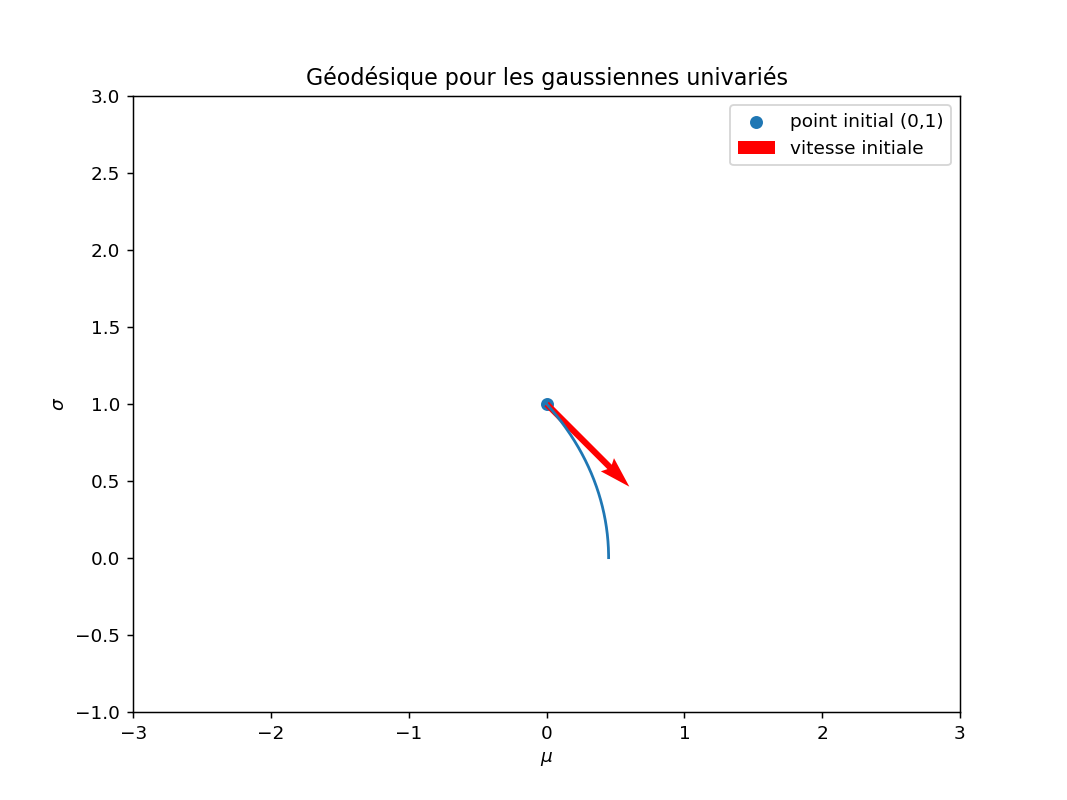

In [7]:
# Application  

Tf = 5    # à choisir 
h =  0.01 # à choisir

#conditions initiales
    # point initial
m_0 = 0
s_0 = 1
    # vecteur initial
dm_0 = 1
ds_0 = -1

Y_0 = np.array([m_0,s_0,dm_0,ds_0])

# on utilise la fonction python solve_geod définie précédemment

X,Y = solve_geod(Tf,h,Y_0) 
plt.figure(figsize=(8,6))
plt.title("Géodésique pour les gaussiennes univariés")
plt.xlim(m_0-3,m_0+3)
plt.ylim(s_0-2,s_0+2)
plt.xlabel('$\mu$')
plt.ylabel('$\sigma$')
plt.plot(X,Y)                                                               # plot de la géodésique
plt.scatter(m_0,s_0, label='point initial ('+str(m_0)+','+str(s_0)+')')      # plot point départ
plt.quiver(m_0,s_0,dm_0,ds_0,scale = 10,color='red',label='vitesse initiale')          # plot vecteur initial
plt.legend();

$\textbf{Question:}$ Que remarque t-on sur la courbure des géodésiques ?

## 3. Boules/Sphères pour la distance de Fisher-Rao 

Nous admettons le résultat suivant

$\textbf{Théorème:}$ Pour toute géodésique $\gamma$ (i.e. résout $\nabla_{\dot \gamma} \dot \gamma = 0$) dans $\mathcal N$, la courbe $\gamma$ est définie sur $\mathbb R^+$ (elle est solution globale) et de plus pour tout $t$ dans $\mathbb R^+$ on a

$$ d(\gamma_0,\gamma_t) = |\dot\gamma_0|_{\gamma_0} t \ \ \ \ (\star).$$


Ce résultat découle du fait que $\mathcal N$ est à courbure strictement négative. La sphère centrée en $\theta_0$ et de rayon $\delta$ pour la distance de Fisher-Rao $d$ est définie par

$$\mathcal S(\theta_0,\delta):= \{ \theta \in \Theta \ | \ d(\theta_0,\theta)=\delta  \}.$$

En considérant des géodésiques $\gamma$ partant d'un $\theta_0$ fixé avec vitesse $\delta$ i.e. $\gamma_0=\theta_0$ et $|\dot \gamma_0|_{\gamma_0}=\delta$ et en prenant $t=1$ dans $(\star)$, on obtient que

$$ d(\theta_0,\gamma_1) = \delta$$

donc $\mathcal S(\theta_0,\delta)$ est caractérisée par les géodésiques à l'instant $t=1$ qui partent de $\theta_0$ avec vitesse $\delta$ i.e. (la surjectivité découle du fait que l'application exponentielle est un difféomorphisme global)

$$ \mathcal S(\theta_0,\delta) = \{\gamma_1 \ | \ \gamma \text{ géodésique t.q. } \gamma_0 = \theta_0 \text{  et  } |\dot \gamma_0|_{\theta_0}= \delta \}.$$

Pour calculer une sphère de Fisher-Rao $\mathcal S(\theta_0,\delta)$ dans $\mathcal N$, nous allons donc prendre des vecteurs $v_i$ tangent en $\theta_0$ et de norme $\delta$ et résoudre numériquement le problème de Cauchy

$$\begin{cases}
\nabla_{\dot \gamma} \dot \gamma = 0,\\
\gamma_0 = \theta_0, \dot \gamma_0 = v_i
\end{cases}
$$

avec la fonction python $\text{solve_geod}$ pour obtenir une approximation de la géodésique $\gamma$ et l'évaluer en $t=1$.

In [8]:
# On créé une fonction qui échantillonne des points sur la sphère

def sample_Fisher_sphere(theta_0,delta,nb_pts,h):
    # theta_0 : centre de la sphère
    # delta : rayon de la sphère
    # h : pas d'approximation dans le calcul de la géodésique
    
    # retourne : la liste des points de la sphère

    # On échantillonne nb_pts points sur l'intervalle [0,2pi]
    Liste_pts = np.linspace(0,2*np.pi,nb_pts)

    C = np.zeros((nb_pts,2))    # Va contenir la liste des points de la sphère approximée
    
    j = 0
    for t in Liste_pts:
        #Ici on prend un vecteur v d'angle t et on le renormalize pour que |v| = delta

        v = np.array([np.cos(t),np.sin(t)]) 
        l = np.sqrt(np.dot(np.transpose(v),np.dot(I(theta_0),v)))
        v = delta*(v/l)

        # Ici on lance le calcul de géodésique en partant de theta_0 avec vecteur vitesse initiale v

        Y_0 = np.array([theta_0[0],theta_0[1],v[0],v[1]])     # on prépare la condition initiale
        Z,W = solve_geod(1,h,Y_0)                             # on résout numériquement la géodésique 
        C[j,:] = np.array([Z[-1],W[-1]])                      # on stocke le point final de la géodésique dans C
        j+=1
    return C

Nous allons maintenant tracer la sphère de Fisher

<IPython.core.display.Javascript object>


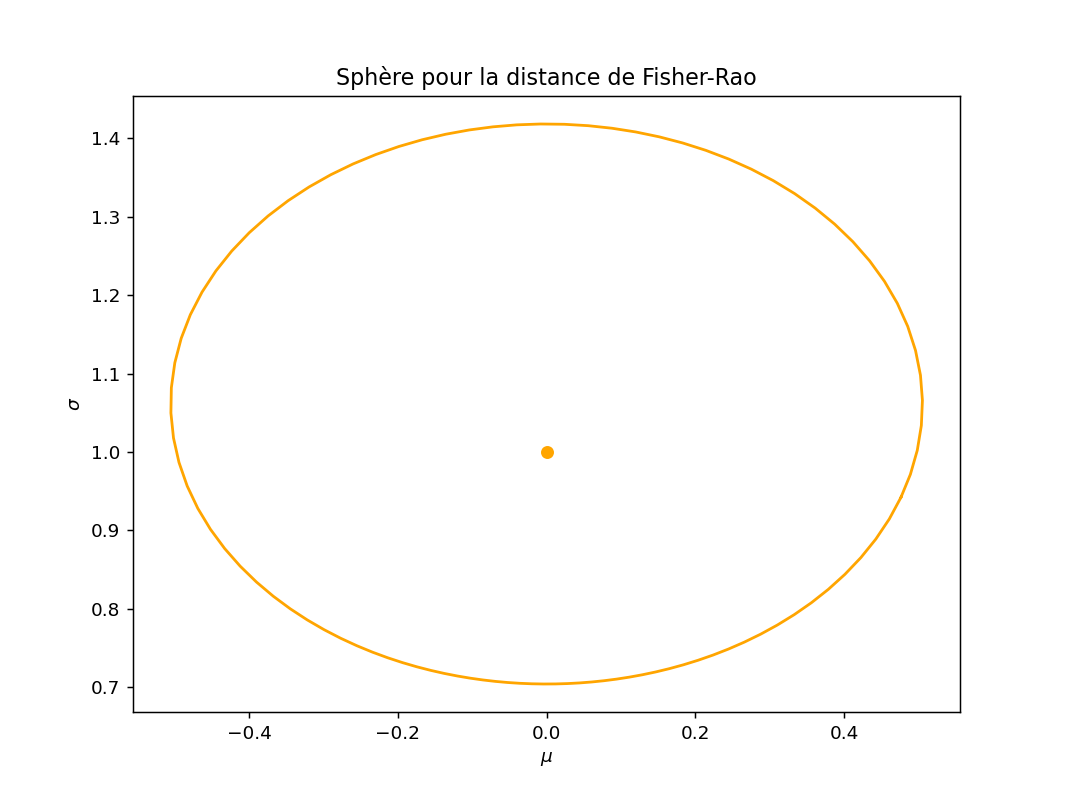

In [10]:
# Centre de la sphère/point initial
theta_0 = np.array([0,1])

# rayon
delta = 0.5

# pas d'approximation des géodésiques
h = 0.01

# nombre d'échantillon sur la sphère 
nb_pts = 100

# On trace la sphère 

C = sample_Fisher_sphere(theta_0,delta,nb_pts,h)
plt.figure(figsize=(8,6))
plt.plot(C[:,0],C[:,1], color ='orange')
plt.scatter(theta_0[0],theta_0[1],color='orange')
#plt.xlim(theta1-4,theta1+4)
#plt.ylim(theta2-3,theta2+3)
plt.xlabel('$\mu$')
plt.ylabel('$\sigma$')
plt.title("Sphère pour la distance de Fisher-Rao");


$\textbf{Question:}$ Que remarque t-on sur la sphère pour la distance géodésique ?

Maintenant qu'on a un algorithme pour approximer les géodésiques, nous voulons coder la distance de Fisher-Rao sur python. Pour les gaussiennes, la distance de Fisher-Rao est connue explicitement, ici nous allons donc l'approximer  en utilisant la méthode de Newton et la comparer à la valeur exacte. Pour deux gaussiennes de paramètres $\theta_1 = \left(\mu_1,\sigma_1\right)$ et $\theta_2 = \left(\mu_2,\sigma_2\right)$ on a la formule d'après [2]

$$d(\mathcal N(\theta_1),\mathcal N(\theta_2)) = \sqrt{2} \log \ \left(\frac{\Big|\left(\frac{\mu_1}{\sqrt{2}},\sigma_1\right) - \left(\frac{\mu_2}{\sqrt{2}},-\sigma_2\right)\Big| + \Big|\left(\frac{\mu_1}{\sqrt{2}},\sigma_1\right) - \left(\frac{\mu_2}{\sqrt{2}},\sigma_2\right)\Big|}{\Big|\left(\frac{\mu_1}{\sqrt{2}},\sigma_1\right) - \left(\frac{\mu_2}{\sqrt{2}},-\sigma_2\right)\Big| - \Big|\left(\frac{\mu_1}{\sqrt{2}},\sigma_1\right) - \left(\frac{\mu_2}{\sqrt{2}},\sigma_2\right)\Big|} \right), $$
 
où $\bar \theta_2 = \left(\frac{\mu_2}{\sqrt 2},-\sigma_2\right)$ et $|\cdot|$ est la norme euclidienne. Cette partie est admise.

In [22]:
def exp(h,p,v): # application exponentielle de pas h
    p1=p[0]
    p2=p[1]
    v1=v[0]
    v2=v[1]
    
    X_0 = np.array([p1,p2,v1,v2])    
    X,Y = solve_geod(1,h,X_0)
    
    return np.array([X[-1],Y[-1]]) 


def dist_Fisher_approx(nb_iter,eps,p,q):
    # nb_iter : nombre d'itération dans la méthode de Newton
    # eps : pas dans la méthode de Newton
    # p,q : les deux points dont on veut calculer la distance
    
    #retourne la distance de Fisher-Rao approximée entre p et q
    
    L = np.zeros((2,2))
    Id = np.identity(2)
    v = q-p
    h = 0.005
    for i in range(nb_iter):
        z = exp(h,p,v)
        
        # Calcul de jacobienne 
        for j in range(2):
            L[:,j] = 1/eps*(exp(h,p,v+eps*Id[j,:]) - z)
        
        grad_z = - z[1]**2*(z-q)
        v = v + eps*np.transpose(np.dot(np.linalg.inv(L),grad_z))
        v = np.array([v[0], v[1]])

    return np.sqrt(np.dot(np.transpose(v), np.dot(I(p),v)  ) ) 

def dist_Fisher_exact(p,q):
    p1,p2 = p[0]/np.sqrt(2),p[1]
    q1,q2 = q[0]/np.sqrt(2),q[1]
    
    N = np.sqrt( (p1- q1)**2 + (p2+q2)**2 ) + np.sqrt((p1- q1)**2 + (p2-q2)**2 ) 
    D = np.sqrt( (p1- q1)**2 + (p2+q2)**2 ) - np.sqrt((p1- q1)**2 + (p2-q2)**2 )
    
    return np.sqrt(2)*np.log(N/D)

In [30]:
p = np.array([0,1])
q = np.array([0,0.00001])

#print('distance approximée entre p et q =',dist_Fisher_approx(1000,0.01,p,q))
print('distance exacte entre p et q =', dist_Fisher_exact(p,q))

distance exacte entre p et q = 16.281735335150056


## 4. Exemple d'analyse de robustesse d'un code numérique

L'utilisation de la géométrie de l'information en analyse de robustesse (AR) pour la quantification d'incertitude à été premièrement proposé dans [1]. Cette nouvelle approche pour l'AR est plus rigoureuse sur le plan théorique par rapport aux méthodes précédentes. L'idée principale dans [1] est d'utiliser la distance de Fisher-Rao pour définir les niveaux de perturbations des distributions en entrées du code.

### 4.1. Principe d'analyse de robustesse en quantification d'incertitude

Le principe de l'analyse de robustesse d'un code $G$, plus précisément l'analyse de robustesse à base de perturbation de loi (PL-RA en anglais), consiste à supposer que les entrées $X=(X_1,...,X_d)$ du code sont incertaines et à modéliser cette incertitude par une distribution $P_0$ (appelé distribution initiale). Cette distribution $P_0$ est elle-même entâchée d'incertitude, on suppose donc qu'elle appartient à une famille paramétrique $\mathcal P = \{P_\theta : \theta \in \Theta\}$ et le but est de voir si une quantité d'intérêt (QoI) de la sortie du code $Y=G(X)$ sera beaucoup affectée ou pas par une variation/perturbation de la distribution initiale $P_{\theta_0}:=P_0$ dans $\mathcal P$. Voici un schéma pour résumé 

$$ \theta \in \Theta \longmapsto X^\theta \sim P_\theta \overset{G}{\longmapsto} Y^\theta:=G(X^\theta) \longmapsto QoI(Y^\theta),$$

on veut étudier comment $QoI(Y^\theta)$ varie quand $\theta$ varie. Cette quantité d'intérêt peut être un $\alpha-$quantile, un $\alpha-$superquantile, la probabilité que $Y$ dépasse un seuil, etc. Dans ce TP, nous allons prendre le cas du quantile

$$QoI(Y) = q_\alpha(Y):= \inf\{t\in \mathbb R : F_Y(t)\geq \alpha \},$$

où $F_Y$ est la fonction de répartition de $Y$. On va par ailleurs noter $f : \Theta \to \mathbb R$ la fonction qui à $\theta$ associe la valeur $QoI(Y^\theta)$ obtenue.

Pour pouvoir étudier la variation de la fonction $f(\theta) = QoI(Y^\theta)$, il faut pouvoir l'estimer pour tout $\theta$ puisqu'une étude directe ne sera pas possible du fait de la complexité du code $G$. Pour cette raison nous allons utiliser la méthode d'échantillonnage par importance (importance sampling) à partir d'un échantillon de $P_{\theta_0}$. Cette méthode nous permettra de constuire un estimateur de $q_\alpha(Y^\theta)$ pour tout $\theta$ avec un échantillon de $P_{\theta_0}$, ce qui nous évitera dévaluer le code plusieurs fois pour chaque $\theta$. Voici la méthode d'échantillonnage par importance:

pour $X_1,...,X_N\sim P_{\theta_0}$ iid, on note $Y_1:=G(X_1),...,Y_N:=G(X_N)$ et la fonction de répartition empirique repondérée de $Y^\theta$ est donnée par 

$$ \hat F_\theta(t) := \frac{1}{\sum_{i=1}^N L_i(\theta)} \sum_{i=1}^N L_{(i)}(\theta) \ \textbf{1}_{Y_{(i)}\leq t}, $$

où $L_i(\theta)=\frac{p_\theta(X_i)}{p_{\theta_0}(X_i)}$ est le rapport de vraisemblance entre $P_\theta$ et $P_{\theta_0}$ évalué en $X_i$. Elle converge p.s. vers la vraie fonction de répartition de $Y^\theta$ par la loi des grands nombres
$$ \forall t\in \mathbb R, \ \hat F_\theta(t) \underset{N\to +\infty}{\longrightarrow} F_{Y^\theta}(t) \ \ \text{p.s.}$$ 

On construit ensuite un estimateur de $q_\alpha(Y^\theta)$ par «plug-in»

$$ \hat q_\alpha(\theta) := \inf\{ t\in \mathbb R : \hat F_\theta(t)) \geq \alpha \},$$

les résultats de convergence asymptotique de cette estimateur se trouvent dans [1]. On notera dans la suite $\hat f (\theta) := \hat q_\alpha(\theta)$.

### 4.2. Comment utiliser la géométrie de l'information ?

La géométrie de l'information permet de définir un niveau de perturbation de loi en utilisant la distance de Fisher-Rao, en supposant que la famille $\mathcal P$ soit régulière pour que cette distance soit bien définie. On dit que $P_\theta$ est une pertubation de $P_{\theta_0}$ de niveau $\delta$ si 

$$ d(P_\theta,P_{\theta_0}) = \delta,$$

on appelle aussi $P_\theta$ une $\delta-$perturbation de $P_{\theta_0}$. Donc, les $\delta-$perturbations de $P_{\theta_0}$ sont exactement les points sur la sphère $\mathcal S(P_{\theta_0},\delta)$ pour la distance de Fisher-Rao. 

$\textbf{But :}$ pour un $\delta$ entre un $\delta_\min$ et  un $\delta_\max$ positif à choisir, le but est de trouver la variation minimale et maximale de la fonction $f$ définie précédemment parmi toute les $\delta-$perturbation de $P_{\theta_0}$ i.e. on veut résoudre les deux problèmes d'optimisation suivants:

$$ \min_{P_\theta \in \mathcal S(P_{\theta_0},\delta) } f(\theta) \ \ \ \text{et} \ \ \ \max_{P_\theta \in \mathcal S(P_{\theta_0},\delta)} f(\theta).$$

 Comme expliqué précedemment, puisque $f(\theta)$ n'est pas connu explicitement, on nous allons la remplacer par $\hat f(\theta)$ et plutôt s'intéresser aux deux problèmes d'optimisation suivants:
$$ \min_{P_\theta \in \mathcal S(P_{\theta_0},\delta) } \hat f(\theta) \ \ \ \text{et} \ \ \ \max_{P_\theta \in \mathcal S(P_{\theta_0},\delta)} \hat f(\theta).$$

### 4.3. Exemple concret : modèle analytique de risque d'inondation (flood risk model)

On regarde $H$ donnée par

$$H = \left( \frac{Q}{300K \sqrt{\frac{Z_m - Z_v}{5000}}}\right)^{0.6}$$

en fonction de $Q$ Gumbel tronquée, $K$ gaussienne tronquée et $Z_m$ et $Z_v$ triangulaires [3]. Ce code calcule le niveau de l'eau d'une rivière et pour ne pas avoir de risque d'inondation $\textbf{il faut que $H$ soit plus petite que 8}$. Nous allons donc regarder le quantile d'ordre $\alpha =0.95$ de la sortie $H$ et voir si ce quantile est plus petit que 8 car on aura

$$q_\alpha(H) \leq 8 \implies \mathbb P(H \leq 8) \geq \alpha = 0.95$$

ce qui garantira que $H$ vérifie le critère avec grande probabilité. Plus de détails se trouvent dans [3] ainsi que dans la documentation de l'outil OpenTurns $\href{http://openturns.github.io/openturns/latest/usecases/usecases.html}{ici}$.

Pour simplifier ici, nous allons fixer les valeurs de $Z_m$, $Z_v$ et $Q$ par leurs valeurs moyennes, nous allons donc voir $G$ comme une fonction de $K$ seulement et faire une étude de robustesse. Le cas général à été traité dans l'annexe du papier [1]. 

Pour $K$, nous allons prendre $\theta_0=(\mu_0,\sigma_0)=(30,7.5)$ et $\delta_\min=0.1$ et $\delta_\max=1.4$ comme dans [1]. Puisque $K$ est une gaussienne tronquée sur $[15,+\infty[$, nous allons définir une fonction python $\text{sample_gaussian_trunc}$ qui nous échantillonnera selon une gaussienne tronquée.

Nous coderons ensuite la fonction $H$ ainsi que les différents quantités définie précédemment (fonction de répartition empirique $\hat F_{Y^\theta}(t)$ et quantile empirique $\hat q_\alpha(\theta)$).

In [98]:
# On fixe d'abord les variables Q, Z_m et Z_v à leurs valeurs moyennes
eulerconst = 0.5772156649
Q = 1013 + 558 * eulerconst  # correspond à la moyenne d'une gumbel G(1013,558)
Z_m = 55      # moyenne triangulaire T(55) tronquée sur [54,56]
Z_v = 50      # moyenne triangulaire T(50) tronquée sur [49,51]


# On définit une fonction qui échantillonne selon une gaussienne tronquée sur [15,+infini[
def sample_gaussian_trunc(theta_0,N):
    S = np.zeros(N)
    for i in range(N):
        k = scs.norm(theta_0[0],theta_0[1]).rvs()
        while k<15:
            k = scs.norm(theta_0[0],theta_0[1]).rvs()
        S[i] = k
    return S

# On définit la fonction H
def H(K):
    D = 300*K*np.sqrt((Z_m-Z_v)/5000)
    return (Q/D)**0.6

#### 4.3.1. Fonction de répartition empirique et quantile empirique

Et maintenant pour la fonction de répartition empirique $\hat F_{Y^\theta}(t)$ et le quantile empirique $\hat q_\alpha(\theta)$:

In [142]:
# On définit la fonction de répartition empirique

    # On définit d'abord le rapport de vraisemblance
    
def likelihood_ratio(th,th0,X):
    
    p_th = scs.norm(th[0],th[1]).pdf(X)
    p_th_0 = scs.norm(th0[0],th0[1]).pdf(X)
    
    return p_th/p_th_0


def F_is(sample,H_val,theta_0,theta,t):
    # sample : échantillon selon la gaussienne de paramètre theta_0
    # H_val : valeur de la fonction H sur l'échantillon
    # theta : paramètre cible pour l'échantillonnage par importance
    # theta_0 : paramètre de la gaussienne initiale
    # t : point(s) d'évaluation pour la fonction de répartition
    
    # retourne : la valeur de la fonction de répartition empirique construite avec l'échantillon sample et 
    # évaluée en t
    
    N=len(sample)
    L = likelihood_ratio(theta,theta_0,sample)  # on évalue le rapport de vraisemblance sur l'échantillon
    G = np.array([H_val, ] * len(t))  # on duplique le array H_val 
    T = np.array([t, ] * len(sample))  # on duplique la liste des points à évaluer

    Bool = G <= T.transpose()       # on regarde le nombre de fois où la fonction dépasse t

    M = np.array([L, ] * len(t))     # on duplique la liste des rapports de vraisemblance
    B = M * Bool                     # on calcule le produit dans la somme
    
    return np.sum(B, axis=1) / np.sum(L)


def quant_estim(sample,H_val,theta_0,theta,alpha):
    # sample : échantillon selon la gaussienne de paramètre theta_0
    # H_val : valeur de la fonction H sur l'échantillon
    # theta : paramètre cible 
    # alpha : ordre du quantile
    
    # retourne : le quantile empirique
    
    
    # on évalue d'abord la fonction de répartition F_is aux points de l'échantillon
    
    F = np.array([F_is(sample,H_val,theta_0,theta,[k]) for k in H_val])
    
    boolean =  F <= alpha  # on regarde quelles valeurs de la f.d.r. dépasse alpha
    
    return np.sort(H_val)[np.sum(boolean)-1]

0.95-quantile de H(K) pour K suivant N(31.0,7.1) estimée par échantillonnage par importance = 3.2226778321613523


<IPython.core.display.Javascript object>


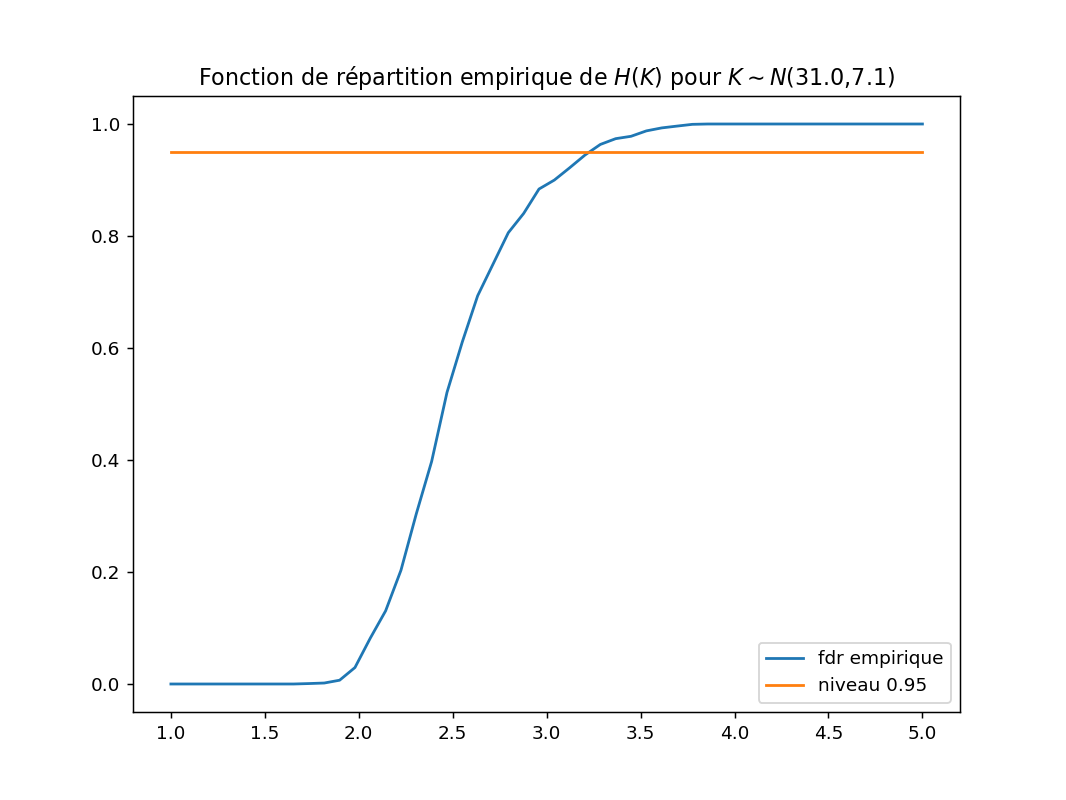

In [181]:
N = 1000
theta_0 = np.array([30,7.5])
theta = np.array([31,7.1])

K = sample_gaussian_trunc(theta_0,N)
H_val = np.array([H(x) for x in K])

print('0.95-quantile de H(K) pour K suivant N('+str(theta[0])+','+str(theta[1])+') estimée par échantillonnage par importance = '+str(quant_estim(K,H_val,theta_0,theta,0.95)))
# Nous allons ici tracer la fonction de répartition empirique
T = np.linspace(1,5,50)
F = F_is(K,H_val,theta_0,theta,T)
plt.figure(figsize=(8,6))
plt.plot(T,F,label="fdr empirique")
plt.plot(T,0.95*np.ones(len(T)),label="niveau 0.95")
plt.title('Fonction de répartition empirique de $H(K)$ pour $K\sim N($'+str(theta[0])+','+str(theta[1])+'$)$' )
plt.legend();

#### 4.3.2. Graphe du quantile empirique $\hat q_\alpha(\theta)$ en fonction de $\theta$ 

Nous allons ensuite tracer le graphe de la fonction quantile estimée en fonction de $\theta = (\mu,\sigma)$ pour $\alpha = 0.95$ sur les sphères de Fisher et faire de l'optimisation brute force.

In [251]:
def valeur_quant_sur_sphere(theta_0,delta,nb_pts,alpha,N,K,H_val):
    
    # theta_0, delta : centre et rayon de la sphère de Fisher
    # nb_pts : nombre de points échantillonné sur la sphère
    # alpha : ordre du quantile
    # N : taille de l'échantillon pour estimer le quantile 
    # K : échantillon selon la loi normale tronquée sur [15,+infini[
    # H_val : valeur de la fonction H sur l'échantillon
    
    # retourne : liste de points sur la sphère et valeur du quantile empirique sur ces points
    
    C = sample_Fisher_sphere(theta_0,delta,nb_pts,0.01)

    return C,np.array([quant_estim(K,H_val,theta_0,theta,alpha) for theta in C])


theta_0 = np.array([30,7.5])
delta = 1
alpha = 0.95
nb_pts = 30
N = 1000
K = sample_gaussian_trunc(theta_0,N)
H_val = np.array([H(x) for x in K])

start = timeit.default_timer()
C,Q_val = valeur_quant_sur_sphere(theta_0,delta,nb_pts,alpha,N,K,H_val)
stop = timeit.default_timer()
print(stop - start,"secondes")

14.979073573020287 secondes


<IPython.core.display.Javascript object>


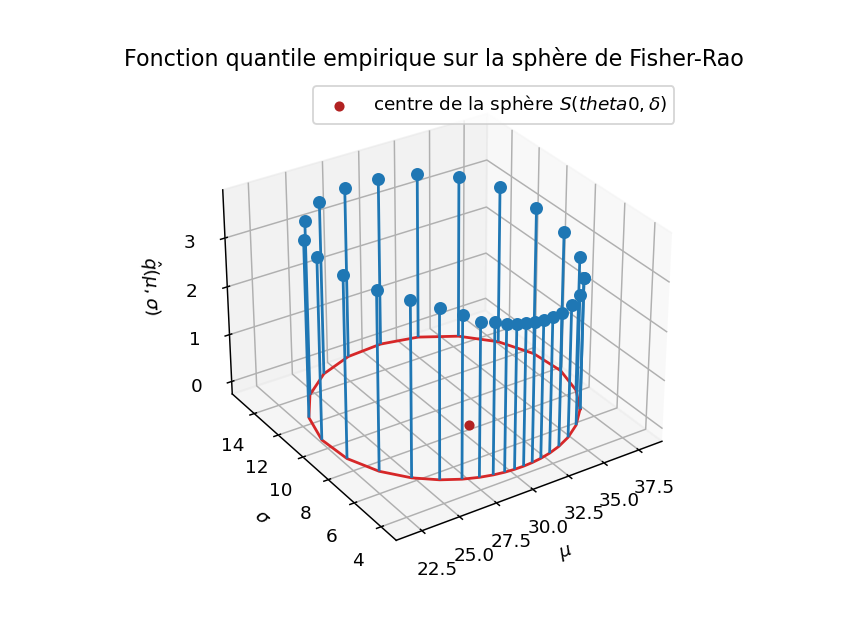

In [227]:
# On va maintenant tracer la fonction quantile empirique sur la sphère
X = C[:,0]
Y = C[:,1]
Z = Q_val

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.stem(X, Y, Q_val)
ax.scatter(theta_0[0],theta_0[1],0,color='firebrick',label = 'centre de la sphère $S(theta0,\delta)$')
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
ax.set_zlabel('$\hat q(\mu,\sigma)$')
plt.legend()
ax.set_title('Fonction quantile empirique sur la sphère de Fisher-Rao ');

#### 4.3.3. Optimisation sur les sphères de Fisher-Rao concentriques de rayon $\delta \in [\delta_\min,\delta_\max]$

Après avoir coder l'estimateur de la fonction quantile $q_\alpha(Y^\theta)$, nous pouvons maintenant optimiser la fonction sur les sphères de Fisher $\mathcal S(\theta_0,\delta)$ pour $\delta \in [\delta_\min,\delta_\max]=[0.1,1.4]$.  

In [211]:
Delta = np.arange(0.1,1.5,0.1)

Liste_min = []
Liste_val_min = []

Liste_max = []
Liste_val_max =[]

theta_0 = np.array([30,7.5])
nb_pts = 30
alpha = 0.95
N = 500
K = sample_gaussian_trunc(theta_0,N)
H_val = np.array([H(x) for x in K])

for delta in Delta:
    C,Q_val = valeur_quant_sur_sphere(theta_0,delta,nb_pts,alpha,N,K,H_val)
    
    minimum,maximum = np.min(Q_val),np.max(Q_val)
    theta_min,theta_max = C[np.argmin(Q_val)],C[np.argmax(Q_val)]
    
    Liste_val_min.append(minimum)
    Liste_val_max.append(maximum)
    
    Liste_min.append(list(theta_min))
    Liste_max.append(list(theta_max))

<IPython.core.display.Javascript object>


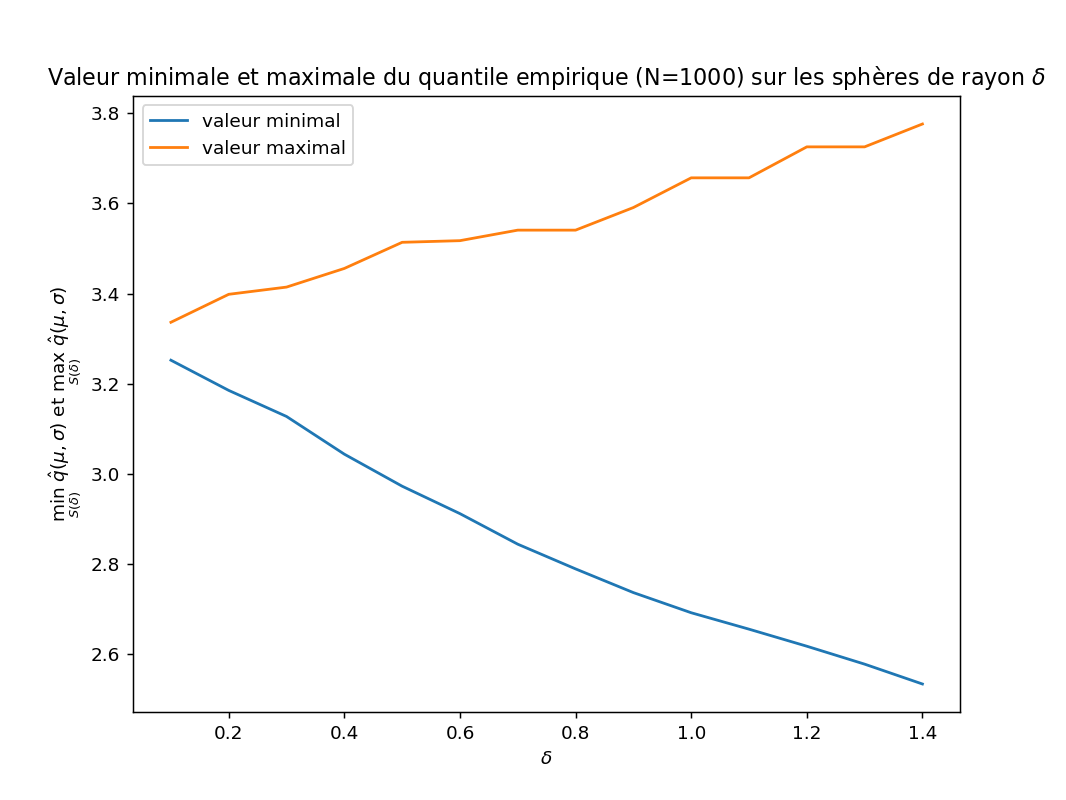

<IPython.core.display.Javascript object>


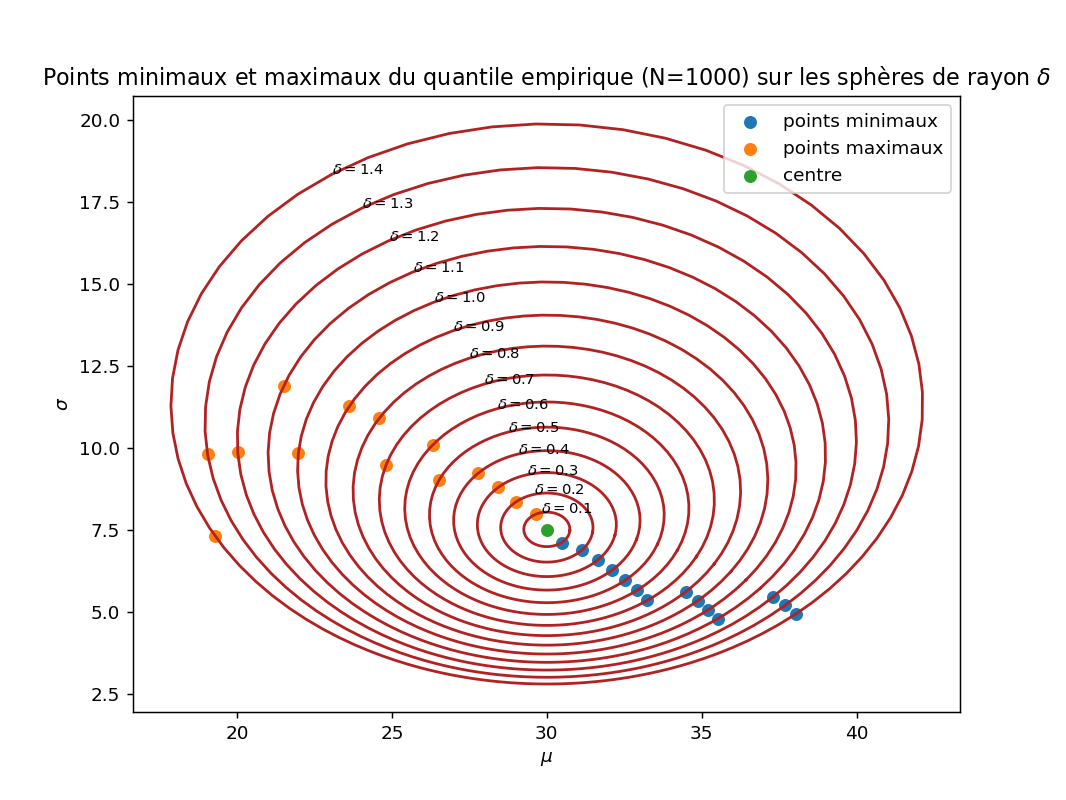

In [248]:
plt.figure(figsize=(8,6))    
plt.plot(Delta,Liste_val_min,label ="valeur minimal")
plt.plot(Delta,Liste_val_max,label ="valeur maximal")
plt.xlabel('$\delta$')
plt.ylabel('$\min_{S(\delta)} \ \hat q(\mu,\sigma)$ et $\max_{S(\delta)} \ \hat q(\mu,\sigma)$')
plt.title('Valeur minimale et maximale du quantile empirique (N='+str(N)+') sur les sphères de rayon $\delta$')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))    
plt.scatter(np.array(Liste_min)[:,0],np.array(Liste_min)[:,1],label ='points minimaux')
plt.scatter(np.array(Liste_max)[:,0],np.array(Liste_max)[:,1],label ='points maximaux')
plt.scatter(theta_0[0],theta_0[1],label ='centre')
plt.title('Points minimaux et maximaux du quantile empirique (N='+str(N)+') sur les sphères de rayon $\delta$')
plt.xlabel('$\mu$')
plt.ylabel('$\sigma$');

for delta in Delta:
    C = sample_Fisher_sphere(theta_0,delta,100,0.01)
    plt.plot(C[:,0],C[:,1],color='firebrick')
    plt.text(C[nb_pts,0], C[nb_pts,1], '$\delta =$'+str(np.floor(10*delta)/10),fontsize = 8)

plt.legend();

## Observations

$\textbf{Question:}$ Que observe t-on sur les valeurs minimales et maximales du quantile empirique ? A t-on dépasser le seuil 8 ?


Puisque les entrées $Q, Z_m, Z_v$ étaient fixées à leurs valeurs moyennes au départ, on peut les faire varier aussi pour voir si cela impactera le quantile. 

Nous rappelons que le quantile empirique $\hat q_\alpha(\theta)$ est définie par:

$$ \hat q_\alpha(\theta) := \inf\{ t\in \mathbb R : \hat F_\theta(t)) \geq \alpha \},$$

on peut remarquer la chose suivante pour le quantile empirique: pour tout $\theta \in \Theta$, la fonction de répartition empirique $\hat F_\theta$ est une fonction constante par morceaux qui saute sur les points $\{Y_{(1)},...,Y_{(N)}\}$. De ce fait la fonction $\theta \to \hat q_\alpha(\theta)$ est à valeur dans  $\{Y_{(1)},...,Y_{(N)}\}$, sa valeur minimale est donc l'une des $Y_{(i_0)}$ avec $i_0 \in \{1,...,N\}$. Donc les $\theta$ minimaux sont caractérisés par $ \hat q_\alpha(\theta) = Y_{(i_0)}$ c'est-à-dire $i_0$ est le premier indice qui vérifie la relation

\begin{align*}
    \hat F_\theta (Y_{(i_0)}) \geq \alpha,
\end{align*} 
ce qui est équivalent à 
$$\frac{\sum_{i=1} ^{i_0} L_{(i)}(\theta)}{\sum_{i=1} ^{N} L_{i}(\theta)} - \alpha \geq 0.$$

Donc, on a démontré que
$$\theta^* \in A_* := \underset{\theta \in \mathcal S(\theta_0,\delta)}{\text{argmin}} \ \ \hat q_\alpha(\theta)$$
est un sous domaine de $\mathcal S(\theta_0,\delta)$ sur lequel le minimum du problème
$$\min_{\theta \in \mathcal S_\theta} \hat q_\alpha(\theta)$$

est atteint. On peut dire la même chose pour le problème de maximisation. Il faut donc retenir qu'on ne peut pas faire de l'optimisation avec descente de gradient car la fonction objectif $\theta \to \hat q_\alpha(\theta)$ est constante par morceaux.

## Conclusion

Nous avons premièrement introduit la géométrie de l'information en utilisant la famille des gaussiennes $\mathcal N$, nous avons pu calculer numériquement les géodésiques et les sphères de Fisher-Rao ainsi qu'approximer la distance de Fisher-Rao avec la méthode de Newton. Ensuite en se basant sur un modèle jouet simplifié, nous avons fait une étude d'analyse de robustesse en utilisant la géométrie de l'information. Voici quelques éléments que l'on peut évoquer pour approfondir cette étude:


1. Pour le cas jouet que nous avons traité, la gaussienne $K$ était tronquée sur l'intervalle $[15,+\infty[$, or les sphères de Fisher que nous avons utilisé comme contrainte pour le problème d'optimisation sont des sphères (pour la distance de Fisher-Rao) dans la famille des gaussiennes non-tronquée. Or, la famille des gaussiennes tronquées admet une matrice d'information de Fisher différente de celle des gaussiennes non-tronquées. De ce fait, la distance de Fisher-Rao est différente ainsi la contrainte du problème d'optimisation sera différente. La famille des gaussiennes tronquées sur $[15,+\infty[$ est donnée par les densités suivantes où $N_{(\mu,\sigma)}$ est la constante de normalisation

$$ q_{(\mu,\sigma)} (x) = \frac{1}{N_{(\mu,\sigma)}}\frac{1}{\sqrt{2\pi}\sigma} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right) \textbf{1}_{x\in [15,+\infty[}. $$

2. Le code que nous avons utilisé dans la partie application est un code analytique dont on a fixé toute sauf une des entrées. Ceci a largement réduit le temps de calcul des estimateurs de la fonction de répartition et du quantile de la sortie du code. Dans la plupart des codes industrielles, un appel au code peut être très coûteux ce qui justifie le choix d'avoir utilisé la méthode d'échantillonnage par importance qui permet d'estimer ces quantités (f.d.r. et quantile) sans avoir besoin de faire appel au code pour chaque $\theta$. Pour compléter l'étude de robustesse, il faut appliquer la même procédure pour les autres entrées du code. Ceci est déjà fait dans l'annexe du papier [1].

3. Le quantile empirique $\hat q_\alpha(\theta)$ est construit pour tout $\theta$ grâce à la méthode d'échantillonnage par importance. Sa convergence en loi ainsi vers le quantile théorique $q_\alpha(Y^\theta)$ est étudiée dans [1], ce qui permet de construire des intervalles de confiance asymptotique. Or dans notre cas, un intervalle de confiance non-asymptotique est plus intéressant puisque nous travaillons à un échantillon de taille $N$ fixé. Un tel intervalle nous permettra d'avoir une garantie sur l'écart entre le quantile empirique et le quantile théorique. 

4. Le choix du $\delta_\max$, qui correspond au plus grand niveau de perturbation, est un problème en soit. Pour des raisons numériques, on ne peut pas prendre un $\delta_\max$ très grand. Mais pour faire une étude de robustesse qui est sûr, il faut avoir un niveau de perturbation maximal assez grand. Or pour l'instant, nous n'avons pas de règle générale pour determiner ce $\delta_\max$.

## Références

[1] Clement Gauchy, Jerome Stenger, Roman Sueur and Bertrand Iooss. An information geometry approach to robustness analysis for the uncertainty quantification of computer codes. Technometrics,
64(1):80–91, 2022

[2] Sueli IR Costa, Sandra A Santos, and Joao E Strapasson. Fisher information distance: A geometrical reading. Discrete Applied Mathematics, 197:59–69, 2015.

[3] Lemaître, Paul, Ekatarina Sergienko, Aurélie Arnaud, Nicolas Bousquet, Fabrice Gamboa, and Bertrand Iooss. Density modification-based reliability sensitivity analysis. Journal of Statistical Computation and Simulation 85, no. 6 (2015): 1200-1223.